In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import math
import PIL
import glob
from PIL import Image
from IPython import display
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten 
from tensorflow.keras.layers import Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import RMSprop,Adam

In [2]:
BATCH_SIZE = 200
IMAGE_SIZE = (28,28,1)
EPOCHS = 100
LATENT_DIM = 64
NUM_EXAMPLES= 16

FIXED_Z = tf.random.normal([NUM_EXAMPLES, LATENT_DIM])

In [3]:
def load_dataset():
    (X_train, y_train) , (X_test, y_test) = load_data()
    X_train = np.expand_dims(X_train,axis=-1)
    X_train = X_train.astype('float32')
    X_train = (X_train/255.0)
    X_train = X_train.reshape(-1,BATCH_SIZE,28,28,1)
    
    return X_train , y_train

In [4]:
X,y = load_dataset()

4423680/4422102 [==============================] - 0s 0us/step


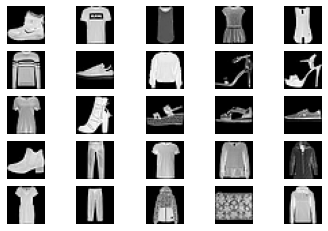

In [5]:
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(X[0][i], cmap='gray')
plt.show()

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*128, input_shape=[LATENT_DIM]))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Reshape((7, 7, 128)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', activation='sigmoid'))

    return model

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Input(shape=(28,28,1)))
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.2))


    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.2))


    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(Dense(1))

    return model

In [8]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,0.5)

In [11]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [12]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [13]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i=0
        
        for image_batch in dataset:
            train_step(image_batch)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, FIXED_Z)

        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,FIXED_Z)

In [14]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i]*255.0)
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

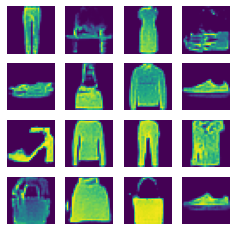

In [15]:
train(X, EPOCHS)

In [16]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [17]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

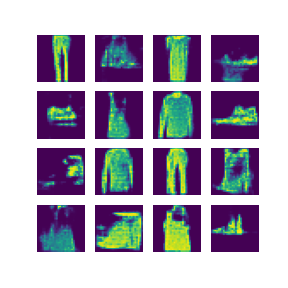

In [18]:
display_image(10)

In [19]:
fp_in = "./image_*.png"
fp_out = "./GAN_training.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=100, loop=0)

In [20]:
noise = np.random.randn(32,64)
pred = generator.predict(noise)

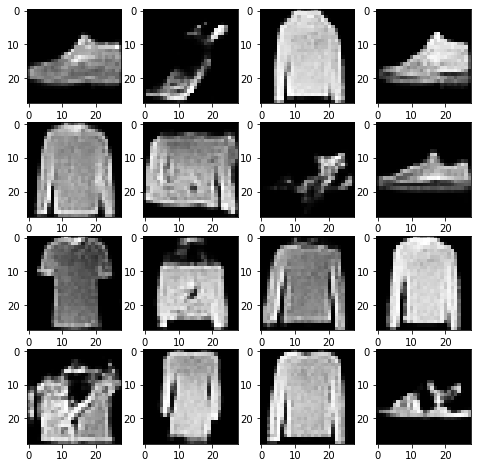

In [21]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(pred[i],cmap='gray')
plt.show()

In [22]:
generator.save('gen_fashion_mnist.hdf5')
discriminator.save('dis_fashion_mnist.hdf5')